In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,SubsetRandomSampler
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Define the transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to the desired size
    transforms.ToTensor(),           # Convert the image to a PyTorch tensor
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalization in imagenet
])

# Define the path to your dataset folder
path = "images"

# Load the dataset
dataset = ImageFolder(root=path, transform=transform)


In [3]:
batch_size = 256  

# Split the dataset into training, validation, and testing sets
train_size = int(0.6 * len(dataset))  # 60% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # Remaining for testing

# Calculate the indices for each subset
train_indices, val_indices, test_indices = torch.utils.data.random_split(
    range(len(dataset)),
    [train_size, val_size, test_size]
)

# Create data loaders for training, validation, and testing
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    # sampler=SubsetRandomSampler(train_indices),
    shuffle=True  
)
val_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_indices),
    shuffle=False 
)
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(test_indices),
    shuffle=False  
)


In [4]:
# Load a pre-trained AlexNet model
alexnet = models.alexnet(weights="AlexNet_Weights.DEFAULT")

num_classes = 5  
alexnet.classifier[6] = nn.Linear(4096, num_classes)


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(alexnet.parameters(), lr=0.001)


In [6]:
train_losses = []
train_accuracies = []
validation_losses = []
validation_accuracies = []

num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
alexnet.to(device)

from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

# Training
for epoch in range(num_epochs):
    alexnet.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    print(f"Epoch [{epoch + 1}/{num_epochs}]")
    train_loader_with_progress = tqdm(train_loader)

    for inputs, labels in train_loader_with_progress:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        train_loader_with_progress.set_postfix({"Loss": loss.item(), "Accuracy": total_correct / total_samples * 100.0})

    average_loss = running_loss / len(train_loader)
    train_losses.append(average_loss)  # Store loss for this epoch

    # Calculate accuracy for this epoch
    epoch_accuracy = total_correct / total_samples * 100.0
    train_accuracies.append(epoch_accuracy)  # Store accuracy for this epoch

    print(f"Training Loss: {average_loss:.4f}, Training Accuracy: {epoch_accuracy:.2f}%")

    # Validation
    alexnet.eval()  # Set the model to evaluation mode
    validation_loss = 0.0
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            val_outputs = alexnet(val_inputs)
            val_loss = criterion(val_outputs, val_labels)
            validation_loss += val_loss.item()

            _, val_predicted = torch.max(val_outputs, 1)
            total_samples_val += val_labels.size(0)
            total_correct_val += (val_predicted == val_labels).sum().item()

    average_validation_loss = validation_loss / len(val_loader)
    validation_losses.append(average_validation_loss)  # Store validation loss for this epoch

    # Calculate validation accuracy for this epoch
    epoch_validation_accuracy = total_correct_val / total_samples_val * 100.0
    validation_accuracies.append(epoch_validation_accuracy)  # Store validation accuracy for this epoch

    print(f"Validation Loss: {average_validation_loss:.4f}, Validation Accuracy: {epoch_validation_accuracy:.2f}%\n")

# # Training accuracy
# training_accuracy = total_correct / total_samples * 100.0
# print(f"Training Accuracy: {training_accuracy:.2f}%")

# Final evaluation on the test set (similar to validation)
# alexnet.eval()
# total_correct_test = 0
# total_samples_test = 0

# with torch.no_grad():
#     for test_inputs, test_labels in test_loader:
#         test_inputs, test_labels = test_inputs.to(device), test_labels.to(device)
#         test_outputs = alexnet(test_inputs)
#         _, test_predicted = torch.max(test_outputs, 1)
#         total_samples_test += test_labels.size(0)
#         total_correct_test += (test_predicted == test_labels).sum().item()

# test_accuracy = total_correct_test / total_samples_test * 100.0
# print(f"Test Accuracy: {test_accuracy:.2f}%")


Epoch [1/10]


100%|██████████| 98/98 [04:03<00:00,  2.48s/it, Loss=0.621, Accuracy=44.9]


Training Loss: 1.2368, Training Accuracy: 44.90%
Validation Loss: 0.7037, Validation Accuracy: 59.06%

Epoch [2/10]


100%|██████████| 98/98 [04:28<00:00,  2.74s/it, Loss=0.336, Accuracy=69.6]


Training Loss: 0.5684, Training Accuracy: 69.60%
Validation Loss: 0.3627, Validation Accuracy: 84.98%

Epoch [3/10]


100%|██████████| 98/98 [04:07<00:00,  2.53s/it, Loss=0.282, Accuracy=83.7]


Training Loss: 0.3974, Training Accuracy: 83.70%
Validation Loss: 0.2892, Validation Accuracy: 89.18%

Epoch [4/10]


100%|██████████| 98/98 [03:32<00:00,  2.17s/it, Loss=0.23, Accuracy=89.4] 


Training Loss: 0.2617, Training Accuracy: 89.41%
Validation Loss: 0.2420, Validation Accuracy: 91.24%

Epoch [5/10]


100%|██████████| 98/98 [04:01<00:00,  2.47s/it, Loss=0.127, Accuracy=93.1] 


Training Loss: 0.1809, Training Accuracy: 93.06%
Validation Loss: 0.1663, Validation Accuracy: 93.52%

Epoch [6/10]


100%|██████████| 98/98 [03:41<00:00,  2.26s/it, Loss=0.0944, Accuracy=94.6]


Training Loss: 0.1362, Training Accuracy: 94.57%
Validation Loss: 0.0958, Validation Accuracy: 96.24%

Epoch [7/10]


100%|██████████| 98/98 [03:58<00:00,  2.44s/it, Loss=0.142, Accuracy=92.4] 


Training Loss: 0.1897, Training Accuracy: 92.44%
Validation Loss: 0.0932, Validation Accuracy: 96.52%

Epoch [8/10]


100%|██████████| 98/98 [03:31<00:00,  2.16s/it, Loss=0.162, Accuracy=94.9] 


Training Loss: 0.1375, Training Accuracy: 94.92%
Validation Loss: 0.2397, Validation Accuracy: 89.82%

Epoch [9/10]


100%|██████████| 98/98 [03:50<00:00,  2.35s/it, Loss=0.0842, Accuracy=95.9]


Training Loss: 0.1044, Training Accuracy: 95.95%
Validation Loss: 0.0558, Validation Accuracy: 98.12%

Epoch [10/10]


100%|██████████| 98/98 [03:44<00:00,  2.29s/it, Loss=0.0407, Accuracy=96.9]


Training Loss: 0.0814, Training Accuracy: 96.85%
Validation Loss: 0.0616, Validation Accuracy: 97.30%



In [7]:
# Evaluation on the test set
alexnet.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0

test_loader_with_progress = tqdm(test_loader)

for inputs, labels in test_loader_with_progress:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = alexnet(inputs)
    _, predicted = torch.max(outputs, 1)
    total_samples += labels.size(0)
    total_correct += (predicted == labels).sum().item()

# Test accuracy
test_accuracy = total_correct / total_samples * 100.0
print(f"Test Accuracy: {test_accuracy:.2f}%")

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [01:07<00:00,  3.37s/it]

Test Accuracy: 97.82%


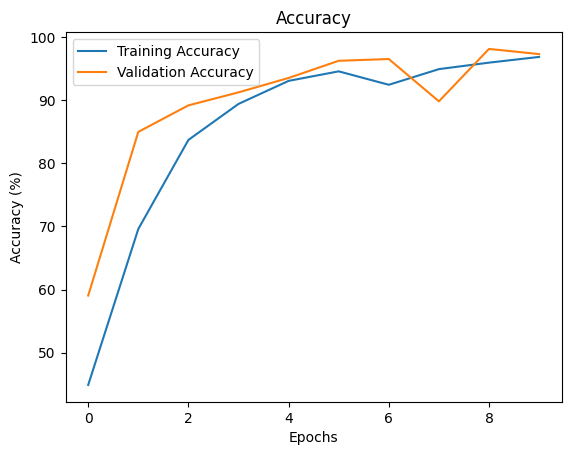

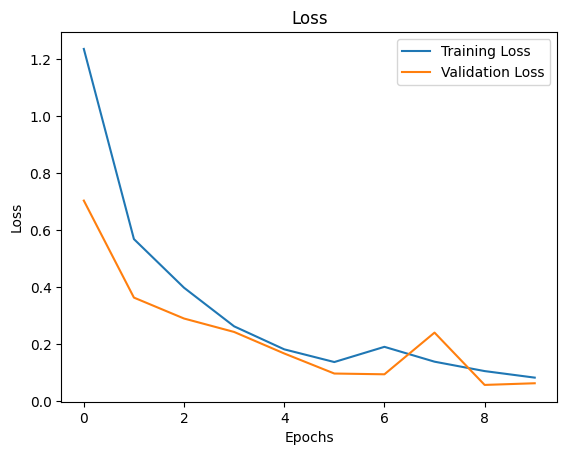

In [8]:
# Plot loss and accuracy

plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')  
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss') 
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss")
plt.legend()
plt.show()

In [9]:
import pandas as pd

data = {
    'Epoch': list(range(1, num_epochs + 1)),
    'Training Loss': train_losses,
    'Training Accuracy (%)': train_accuracies,
    'Validation Loss': validation_losses,
    'Validation Accuracy (%)': validation_accuracies,
}

df_train = pd.DataFrame(data)

df_train.to_csv('alexnet_training_metrics.csv', index=False)


In [10]:
torch.save(alexnet.state_dict(), "alexnet.pth")